In [1]:
import os
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from efficient_net_pytorch import EfficientNet
from sklearn.metrics import classification_report, accuracy_score

from IPython.display import clear_output
clear_output()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
eff_net = dict()
eff_net_pretrained = dict()

In [3]:
for i in range(9):
    key = "b" + str(i)
    name = "efficientnet-" + key
    net = EfficientNet.from_name(name, override_params={'num_classes': 101})
    eff_net[key] = net
clear_output()

In [4]:
for i in [0, 2, 4]:
    key = "b" + str(i)
    name = "efficientnet-" + key
    net = EfficientNet.from_pretrained(name, num_classes=101)
    eff_net_pretrained[key] = net
clear_output()   

## Prepare data

In [5]:
def get_dataset(model_name="b0"):
    resolution = EfficientNet.get_image_size("efficientnet-" + model_name)
    tfms = transforms.Compose([#transforms.Resize((300, 200)), 
                               transforms.Resize(resolution),
                               transforms.CenterCrop(resolution), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])
    cal_tech101 = ImageFolder(
        root = "./data/101_ObjectCategories",
        transform = tfms
    )
    # Train 60%, val 20%, test 20%
    train_size = int(0.6 * len(cal_tech101))
    test_size = int(0.2 * len(cal_tech101))
    val_size = len(cal_tech101) - train_size - test_size
    train_data, val_data, test_data = random_split(cal_tech101, [train_size, val_size, test_size])

    return train_data, val_data, test_data

## Utils

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def plot_graph(loss_list, accuracy_list):
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    plt.plot(range(len(loss_list)), loss_list, color="green")
#     plt.xticks(range(len(loss_list)))
    plt.ylabel("LOSS")
    plt.xlabel("Recorded after every 50 mini batches")
    plt.subplot(122)
    plt.plot(range(len(accuracy_list)), accuracy_list, color="orange")
#     plt.xticks(range(len(loss_list)))
    plt.ylabel("ACCURACY")
    plt.xlabel("Recorded after every 50 mini batches")
    plt.ylim(0,1)
    plt.show()

## Train & Eval

In [8]:
def train(model, optim, train_data, val_data, epochs, batch_size):
    loss_list, accuracy_list = list(), list()
    criterion = nn.CrossEntropyLoss().to(device)
    model.to(device)
    model.train()
    dataloader = DataLoader(train_data, batch_size, shuffle=True)
    loss_meter = AverageMeter()
    for epoch in range(epochs):
        print("EPOCH: ", epoch)
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            optim.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            loss_meter.update(loss.item(), inputs.size(0))
            if batch_idx % 50 == 0:
                accuracy = evaluate(model, val_data, batch_size)
                print(f"   BATCH: {batch_idx:>3}, TRAIN_LOSS: {loss_meter.avg:.4f}, VAL_ACCU: {accuracy:.2f}")
                loss_list.append(loss_meter.avg)
                accuracy_list.append(accuracy)
                loss_meter.reset()
            loss.backward()
            optim.step()
    return loss_list, accuracy_list

In [9]:
def evaluate(model, data, batch_size=32, print_accu=False):  
    model.eval()
    accuracy_meter = AverageMeter()
    dataloader = DataLoader(data, batch_size, shuffle=False)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader): 
            outputs = model(inputs.to(device))
            outputs = torch.topk(outputs, k=1).indices.squeeze(0).flatten().cpu().tolist()
            targets = targets.flatten().cpu().tolist()
            accuracy_meter.update(accuracy_score(outputs, targets), len(targets))
    model.train()
    if print_accu:
        percentage = accuracy_meter.avg*100
        print(f"VALIDATE ACCURACY: {percentage:.2f}%")
    else:
        return accuracy_meter.avg

## B0 - no pretrained weights

In [9]:
model_name = "b0"
model = eff_net[model_name]
optim = torch.optim.Adam(model.parameters())
train_data, val_data, test_data = get_dataset(model_name)
epochs = 25
batch_size = 32

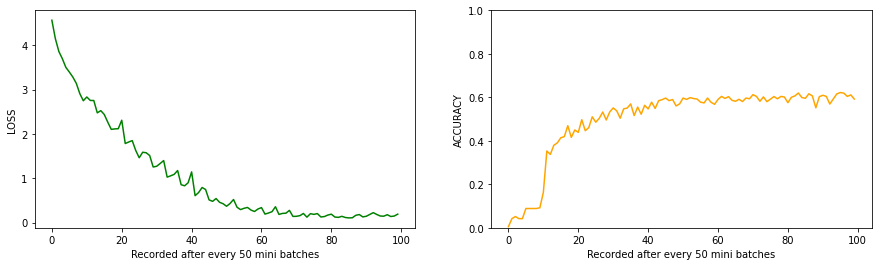

In [37]:
loss_list, accuracy_list = train(model, optim, train_data, val_data, epochs, batch_size)
clear_output()
plot_graph(loss_list, accuracy_list)

In [38]:
evaluate(model, test_data, print_accu=True)

VALIDATE ACCURACY: 56.83%


## B0 - w/ pretrained weights

In [23]:
model_name = "b0"
model = eff_net_pretrained[model_name]
optim = torch.optim.Adam(model.parameters())
train_data, val_data, test_data = get_dataset(model_name)
epochs = 25
batch_size = 32

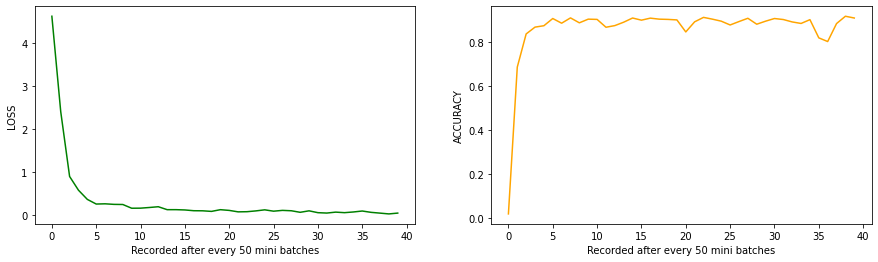

In [24]:
loss_list, accuracy_list = train(model, optim, train_data, val_data, epochs, batch_size)
clear_output()
plot_graph(loss_list, accuracy_list)

In [25]:
evaluate(model, test_data, print_accu=True)

VALIDATE ACCURACY: 91.35%


## B2 - no pretrained weights

In [10]:
model_name = "b2"
model = eff_net[model_name]
optim = torch.optim.Adam(model.parameters())
train_data, val_data, test_data = get_dataset(model_name)
epochs = 25
batch_size = 32

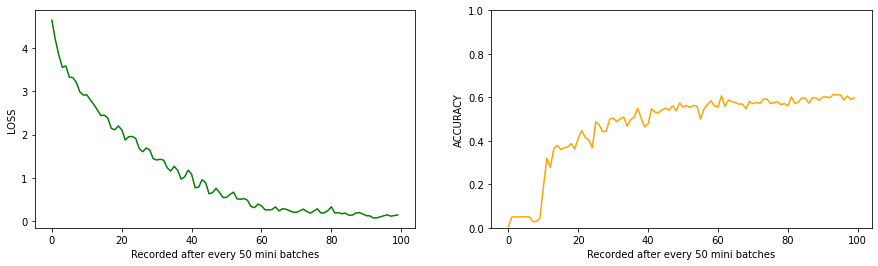

In [11]:
loss_list, accuracy_list = train(model, optim, train_data, val_data, epochs, batch_size)
clear_output()
plot_graph(loss_list, accuracy_list)

In [12]:
evaluate(model, test_data, print_accu=True)

VALIDATE ACCURACY: 57.41%


## B2 - w/ pretrained weights

In [15]:
model_name = "b2"
model = eff_net_pretrained[model_name]
optim = torch.optim.Adam(model.parameters())
train_data, val_data, test_data = get_dataset(model_name)
epochs = 25
batch_size = 32

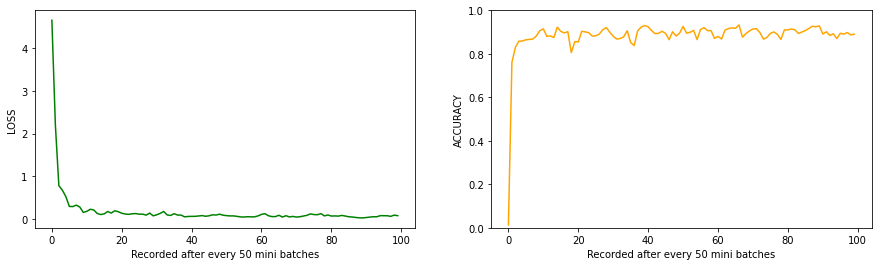

In [16]:
loss_list, accuracy_list = train(model, optim, train_data, val_data, epochs, batch_size)
clear_output()
plot_graph(loss_list, accuracy_list)

In [17]:
evaluate(model, test_data, print_accu=True)

VALIDATE ACCURACY: 88.53%


## B4 - no pretrained weights

In [10]:
model_name = "b4"
model = eff_net[model_name]
optim = torch.optim.Adam(model.parameters())
train_data, val_data, test_data = get_dataset(model_name)
epochs = 25
batch_size = 32

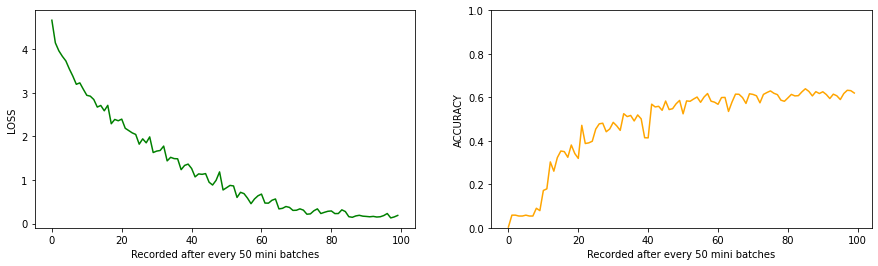

In [11]:
loss_list, accuracy_list = train(model, optim, train_data, val_data, epochs, batch_size)
clear_output()
plot_graph(loss_list, accuracy_list)

In [12]:
evaluate(model, test_data, print_accu=True)

VALIDATE ACCURACY: 61.50%


## B4 - w/ pretrained weights

In [13]:
model_name = "b4"
model = eff_net_pretrained[model_name]
optim = torch.optim.Adam(model.parameters())
train_data, val_data, test_data = get_dataset(model_name)
epochs = 10
batch_size = 32

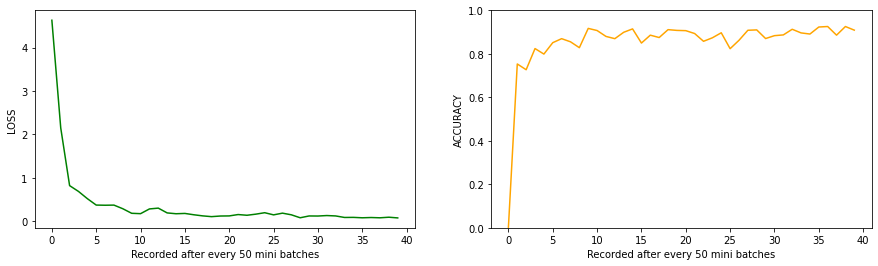

In [14]:
loss_list, accuracy_list = train(model, optim, train_data, val_data, epochs, batch_size)
clear_output()
plot_graph(loss_list, accuracy_list)

In [15]:
evaluate(model, test_data, print_accu=True)

VALIDATE ACCURACY: 90.43%
